# Utils

In [1]:
from scipy.signal import lfilter
import matplotlib.pyplot as plt

def update_target_graph(from_scope, to_scope):
    """
    Copies one set of variables to another.
    Used to set worker network parameters to those of global network.
    """
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)

    op_holder = []
    for from_var, to_var in zip(from_vars, to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder


def discount(x, gamma):
    """
    Discounting function used to calculate discounted returns.
    """
    return lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]


def normalized_columns_initializer(std=1.0):
    """
    Used to initialize weights for policy and value output layers
    """
    def _initializer(shape, dtype=None, partition_info=None):
        out = np.random.randn(*shape).astype(np.float32)
        out *= std / np.sqrt(np.square(out).sum(axis=0, keepdims=True))
        return tf.constant(out)
    return _initializer


def look_for_folder(main_folder='priors/', exp=''):
    """
    looks for a given folder and returns it.
    If it cannot find it, returns possible candidates
    """
    data_path = ''
    possibilities = []
    for root, dirs, files in os.walk(main_folder):
        ind = root.rfind('/')
        possibilities.append(root[ind+1:])
        if root[ind+1:] == exp:
            data_path = root
            break

    if data_path == '':
        candidates = difflib.get_close_matches(exp, possibilities,
                                               n=1, cutoff=0.)
        print(exp + ' NOT FOUND IN ' + main_folder)
        if len(candidates) > 0:
            print('possible candidates:')
            print(candidates)

    return data_path


def list_str(l):
    """
    list to str
    """
    nice_string = str(l[0])
    for ind_el in range(1, len(l)):
        nice_string += '_'+str(l[ind_el])
    return nice_string


def num2str(num):
    """
    pass big number to thousands
    """
    return str(int(num/1000))+'K'


def rm_lines():
    ax = plt.gca()
    ax.clear()


def plot_trials_start(trials, minimo, maximo, num_steps, color='k'):
    trials = np.nonzero(trials)[0] - 0.5
    cond = np.logical_and(trials >= 0, trials <= num_steps)
    trials = trials[np.where(cond)]
    for ind_tr in range(len(trials)):
        plt.plot([trials[ind_tr], trials[ind_tr]], [minimo, maximo],
                 '--'+color, lw=1)
    plt.xlim(0-0.5, num_steps-0.5)

# Analysis

In [2]:
%matplotlib notebook
from scipy.optimize import curve_fit
from scipy.special import erf



def plot_learning(performance, evidence, stim_position, action):
    """
    plots RNN and ideal observer performances.
    The function assumes that a figure has been created
    before it is called.
    """
    # remove all previous plots
    rm_lines()
    # ideal observer choice
    io_choice = evidence < 0
    io_performance = io_choice == stim_position
    # save the mean performances
    RNN_perf = np.mean(performance[:, 2000:].flatten())
    io_perf = np.mean(io_performance[:, 2000:].flatten())

    w_conv = 200  # this is for the smoothing
    # plot smoothed performance
    performance_smoothed = np.convolve(np.mean(performance, axis=0),
                                       np.ones((w_conv,))/w_conv,
                                       mode='valid')
    plt.plot(performance_smoothed, color=(0.39, 0.39, 0.39), lw=0.5,
             label='RNN perf. (' + str(round(RNN_perf, 3)) + ')')

    # plot ideal observer performance
    io_perf_smoothed = np.convolve(np.mean(io_performance, axis=0),
                                   np.ones((w_conv,))/w_conv,
                                   mode='valid')
    plt.plot(io_perf_smoothed, color=(1, 0.8, 0.5), lw=0.5,
             label='Ideal Obs. perf. (' + str(round(io_perf, 3)) + ')')
    # plot 0.25, 0.5 and 0.75 performance lines
    plot_fractions([0, performance.shape[1]])
    plt.title('performance')
    plt.xlabel('trials')
    plt.legend()

def plot_fractions(lims):
    """
    plot dashed lines for 0.25, 0.5 and 0.75
    """
    plt.plot(lims, [0.25, 0.25], '--k', lw=0.25)
    plt.plot(lims, [0.5, 0.5], '--k', lw=0.25)
    plt.plot(lims, [0.75, 0.75], '--k', lw=0.25)
    plt.xlim(lims[0], lims[1])


def plot_psychometric_curves(evidence, performance, action,
                             blk_dur=200,
                             plt_av=True, figs=True):
    """
    plots psychometric curves
    - evidence for right VS prob. of choosing right
    - evidence for repeating side VS prob. of repeating
    - same as above but conditionated on hits and fails
    The function assumes that a figure has been created 
    before it is called.
    """
    # build the mat that indicates the current block
    rep_prob = build_block_mat(evidence.shape, blk_dur)

    # repeating probs. values
    probs_vals = np.unique(rep_prob)
    assert len(probs_vals) <= 2
    colors = [[1, 0, 0], [0, 0, 1]]
    if figs:
        rows = 2
        cols = 2
    else:
        rows = 0
        cols = 0

    data = {}
    for ind_sp in range(4):
        plt.subplot(rows, cols, ind_sp+1)
        # remove all previous plots
        rm_lines()
    for ind_blk in range(len(probs_vals)):
        # filter data
        inds = (rep_prob == probs_vals[ind_blk])
        evidence_block = evidence[inds]
        performance_block = performance[inds]
        action_block = action[inds]
        data = get_psyCho_curves_data(performance_block,
                                      evidence_block, action_block,
                                      probs_vals[ind_blk],
                                      rows, cols, figs, colors[ind_blk],
                                      plt_av, data)
    return data


def get_psyCho_curves_data(performance, evidence, action, prob,
                           rows, cols, figs, color, plt_av, data):
    """
    plot psychometric curves for:
    right evidence VS prob. choosing right
    repeating evidence VS prob. repeating
    repeating evidence VS prob. repeating (conditionated on previous correct)
    repeating evidence VS prob. repeating (conditionated on previous wrong)
    """

    # 1. RIGHT EVIDENCE VS PROB. CHOOSING RIGHT
    # get the action
    right_choice = action == 0

    # associate invalid trials (network fixates) with random choice
    right_choice[action == 2] = evidence[action == 2] > 0
    # np.random.choice([0, 1], size=(np.sum(action.flatten() == 2),))

    # convert the choice to float and flatten it
    right_choice = [float(x) for x in right_choice]
    right_choice = np.asarray(right_choice)
    # fit and plot
    if figs:
        plt.subplot(rows, cols, 1)
        plt.xlabel('right evidence')
        plt.ylabel('prob. right')
    popt, pcov, av_data =\
        fit_and_plot(evidence, right_choice,
                     plt_av, color=color, figs=figs)

    data['popt_rightProb_' + str(prob)] = popt
    data['pcov_rightProb_' + str(prob)] = pcov
    data['av_rightProb_' + str(prob)] = av_data

    # 2. REPEATING EVIDENCE VS PROB. REPEATING
    # I add a random choice to the beginning of the choice matrix
    # and differentiate to see when the network is repeating sides
    repeat = np.concatenate(
        (np.array(np.random.choice([0, 1])).reshape(1,),
         right_choice))
    repeat = np.diff(repeat) == 0
    # right_choice_repeating is just the original right_choice mat
    # but shifted one element to the left.
    right_choice_repeating = np.concatenate(
        (np.array(np.random.choice([0, 1])).reshape(1, ),
         right_choice[:-1]))
    # the rep. evidence is the original evidence with a negative sign
    # if the repeating side is the left one
    rep_ev_block = evidence *\
        (-1)**(right_choice_repeating == 0)
    # fitting
    if figs:
        label_aux = 'p. rep.: ' + str(prob)
        plt.subplot(rows, cols, 2)
        #         plt.xlabel('repetition evidence')
        #         plt.ylabel('prob. repetition')
    else:
        label_aux = ''
    popt, pcov, av_data =\
        fit_and_plot(rep_ev_block, repeat,
                     plt_av, color=color,
                     label=label_aux, figs=figs)

    data['popt_repProb_'+str(prob)] = popt
    data['pcov_repProb_'+str(prob)] = pcov
    data['av_repProb_'+str(prob)] = av_data

    # plot psycho-curves conditionated on previous performance
    # get previous trial performance
    prev_perf = np.concatenate(
        (np.array(np.random.choice([0, 1])).reshape(1,),
         performance[:-1]))
    # 3. REPEATING EVIDENCE VS PROB. REPEATING (conditionated on previous correct)
    # fitting
    mask = prev_perf == 1
    if figs:
        plt.subplot(rows, cols, 3)
        plt.xlabel('repetition evidence')
        plt.ylabel('prob. repetition')
        #         plt.title('Prev. hit')
    popt, pcov, av_data =\
        fit_and_plot(rep_ev_block[mask], repeat[mask],
                     plt_av, color=color,
                     label=label_aux, figs=figs)

    data['popt_repProb_hits_'+str(prob)] = popt
    data['pcov_repProb_hits_'+str(prob)] = pcov
    data['av_repProb_hits_'+str(prob)] = av_data

    # 4. REPEATING EVIDENCE VS PROB. REPEATING (conditionated on previous wrong)
    # fitting
    mask = prev_perf == 0
    if figs:
        plt.subplot(rows, cols, 4)
        plt.xlabel('repetition evidence')
        #         plt.ylabel('prob. repetition')
        #         plt.title('Prev. fail')
    popt, pcov, av_data =\
        fit_and_plot(rep_ev_block[mask], repeat[mask],
                     plt_av, color=color,
                     label=label_aux, figs=figs)

    data['popt_repProb_fails_'+str(prob)] = popt
    data['pcov_repProb_fails_'+str(prob)] = pcov
    data['av_repProb_fails_'+str(prob)] = av_data

    return data


def fit_and_plot(evidence, choice, plt_av=False,
                 color=(0, 0, 0), label='', figs=False):
    """
    uses curve_fit to fit the evidence/choice provided to a probit function
    that takes into account the lapse rates
    it also plots the corresponding fit and, if plt_av=True, plots the
    average choice values for different windows of the evidence
    """
    if evidence.shape[0] > 10 and len(np.unique(choice)) == 2:
        # fit
        popt, pcov = curve_fit(probit_lapse_rates,
                               evidence, choice, maxfev=10000)
    # plot averages
        if plt_av:
            av_data = plot_psychoCurves_averages(evidence, choice,
                                                 color=color, figs=figs)
        else:
            av_data = {}
        # plot obtained probit function
        if figs:
            x = np.linspace(np.min(evidence),
                            np.max(evidence), 50)
            # get the y values for the fitting
            y = probit_lapse_rates(x, popt[0], popt[1], popt[2], popt[3])
            if label == '':
                plt.plot(x, y, color=color, lw=0.5)
            else:
                plt.plot(x, y, color=color,  label=label
                         + ' b: ' + str(round(popt[1], 3)), lw=0.5)
                # plt.legend(loc="lower right")
            plot_dashed_lines(-np.max(evidence), np.max(evidence))
    else:
        av_data = {}
        popt = [0, 0, 0, 0]
        pcov = 0
        print('not enough data!')
    return popt, pcov, av_data


def plot_psychoCurves_averages(x_values, y_values,
                               color=(0, 0, 0), figs=False):
    """
    plots average values of y_values for 10 (num_values) different windows
    in x_values
    """
    num_values = 10
    conf = 0.95
    x, step = np.linspace(np.min(x_values), np.max(x_values),
                          num_values, retstep=True)
    curve_mean = []
    curve_std = []
    # compute mean for each window
    for ind_x in range(num_values-1):
        inds = (x_values >= x[ind_x])*(x_values < x[ind_x+1])
        mean = np.mean(y_values[inds])
        curve_mean.append(mean)
        curve_std.append(conf*np.sqrt(mean*(1-mean)/np.sum(inds)))

    if figs:
        # make color weaker
        # np.max(np.concatenate((color, [1, 1, 1]), axis=0), axis=0)
        color_w = np.array(color) + 0.5
        color_w[color_w > 1] = 1
        # plot
        plt.errorbar(x[:-1] + step / 2, curve_mean, curve_std,
                     color=color_w, marker='+', linestyle='')

    # put values in a dictionary
    av_data = {'mean': curve_mean, 'std': curve_std, 'x': x[:-1]+step/2}
    return av_data


def build_block_mat(shape, block_dur):
    # build rep. prob vector
    rp_mat = np.zeros(shape)
    a = np.arange(shape[1])
    b = np.floor(a/block_dur)
    rp_mat[:, b % 2 == 0] = 1
    return rp_mat


def probit_lapse_rates(x, beta, alpha, piL, piR):
    piR = 0
    piL = 0
    probit_lr = piR + (1 - piL - piR) * probit(x, beta, alpha)
    return probit_lr


def probit(x, beta, alpha):
    probit = 1/2*(1+erf((beta*x+alpha)/np.sqrt(2)))
    return probit


def plot_dashed_lines(minimo, maximo):
    plt.plot([0, 0], [0, 1], '--k', lw=0.2)
    plt.plot([minimo, maximo], [0.5, 0.5], '--k', lw=0.2)
    

def plot_trials(folder, num_steps, num_trials):
    num_rows = 6
    for ind_sp in range(num_rows):
        plt.subplot(num_rows, 1, ind_sp+1)
        # remove all previous plots
        rm_lines()
    data = np.load(folder + '/all_points_' + str(num_trials) + '.npz')
    new_tr_flag = data['new_trial_flags']
    # plot the stimulus
    plt.subplot(num_rows, 1, 1)
    states = data['states']
    shape_aux = (states.shape[0], states.shape[2])
    states = np.reshape(states, shape_aux)[0:num_steps, :]
    plt.imshow(states[:, 0:2].T, aspect='auto', cmap='gray')
    minimo = -0.5
    maximo = 1.5
    plot_trials_start(new_tr_flag, minimo, maximo, num_steps, color='y')

    plt.ylabel('stim')
    plt.xticks([])
    plt.yticks([])

    # go over trials and compute cumulative evidence
    trials = np.nonzero(new_tr_flag)[0]
    trials = np.concatenate((np.array([-1]), trials))
    plt.subplot(num_rows, 1, 2)
    evidence = np.zeros((num_steps,))
    for ind_time in range(num_steps):
        if ind_time in trials:
            # the cumulative evidence is 0 in the beginning
            evidence[ind_time] = 0
        else:
            # 0 belongs to trials so this is always valid
            previous_evidence = evidence[ind_time-1]
            evidence[ind_time] = previous_evidence +\
                (states[ind_time, 0]-states[ind_time, 1])

    # plot evidence
    plt.plot(evidence)
    plt.plot([0, num_steps], [0, 0], '--k', lw=0.5)
    plt.xlim(-0.5, 99.5)
    plot_trials_start(new_tr_flag,
                      np.min(evidence), np.max(evidence), num_steps)
    plt.ylabel('evidence')
    plt.xticks([])
    plt.plot(new_tr_flag)
    # plot actions
    actions = data['actions']
    actions = np.reshape(actions, (1, -1))
    minimo = -0.5
    maximo = 0.5
    plt.subplot(num_rows, 1, 3)
    plt.imshow(actions, aspect='auto', cmap='viridis')
    plot_trials_start(new_tr_flag, minimo, maximo, num_steps, color='w')
    plt.ylabel('action')
    plt.xticks([])
    plt.yticks([])
    # plot the rewards
    rewards = data['rewards']
    rewards = np.reshape(rewards, (1, -1))
    minimo = -0.5
    maximo = 0.5
    plt.subplot(num_rows, 1, 4)
    plt.imshow(rewards, aspect='auto', cmap='jet')
    plot_trials_start(new_tr_flag, minimo, maximo, num_steps, color='w')
    plt.ylabel('reward')
    plt.xticks([])
    plt.yticks([])
    
    # plot the performance
    performance = np.array(data['corrects'])[0:num_steps, :]
    performance = performance.T
    minimo = -0.5
    maximo = 0.5
    plt.subplot(num_rows, 1, 5)
    plt.imshow(performance, aspect='auto', cmap='jet')
    plot_trials_start(new_tr_flag, minimo, maximo, num_steps, color='w')
    plt.ylabel('correct')
    plt.xticks([])
    plt.yticks([])
    
    # plot the ground truth
    plt.subplot(num_rows, 1, 6)
    states = data['stims_conf']==1.0
    states = states[0:num_steps, :]
    plt.imshow(states[:, 0:2].T, aspect='auto', cmap='gray')
    minimo = -0.5
    maximo = 1.5
    plot_trials_start(new_tr_flag, minimo, maximo, num_steps, color='y')

    plt.ylabel('gr. truth')
    plt.xticks([])
    plt.yticks([])

    
    # plot neurons' activities
    if len(data['net_state']) != 0:
        activity = data['net_state']
        plt.subplot(num_rows, 1, 6)
        shape_aux = (activity.shape[0], activity.shape[2])
        activity = np.reshape(activity, shape_aux)[0:num_steps, :]
        maximo = np.max(activity, axis=0).reshape(1, activity.shape[1])
        activity /= maximo
        activity[np.isnan(activity)] = -0.1
        plt.imshow(activity.T, aspect='auto', cmap='hot')
        minimo = np.min(-0.5)
        maximo = np.max(shape_aux[1]-0.5)
        plot_trials_start(new_tr_flag, minimo, maximo, num_steps)
        plt.ylabel('activity')
        plt.xlabel('time (a.u)')
        plt.yticks([])

# Network

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim

def RNN_UGRU(inputs, prev_rewards, a_size, num_units):

    # create a UGRNNCell
    rnn_cell = tf.contrib.rnn.UGRNNCell(num_units, activation=tf.nn.relu)

    # this is the initial state used in the A3C model when training
    # or obtaining an action
    st_init = np.zeros((1, rnn_cell.state_size), np.float32)

    # defining initial state
    state_in = tf.placeholder(tf.float32, [1, rnn_cell.state_size])

    # reshape inputs size
    rnn_in = tf.expand_dims(inputs, [0])

    step_size = tf.shape(prev_rewards)[:1]

    # 'state' is a tensor of shape [batch_size, cell_state_size]
    # 'outputs' is a tensor of shape [batch_size, max_time, cell_state_size]
    outputs, state_out = tf.nn.dynamic_rnn(rnn_cell, rnn_in,
                                           initial_state=state_in,
                                           sequence_length=step_size,
                                           dtype=tf.float32,
                                           time_major=False)

    rnn_out = tf.reshape(outputs, [-1, num_units])

    actions, actions_onehot, policy, value = \
        process_output(rnn_out, outputs, a_size, num_units)

    return st_init, state_in, state_out, actions, actions_onehot, policy, value

def process_output(rnn_out, outputs, a_size, num_units):
    # Actions
    actions = tf.placeholder(shape=[None], dtype=tf.int32)
    actions_onehot = tf.one_hot(actions, a_size, dtype=tf.float32)

    # Output layers for policy and value estimations
    policy = slim.fully_connected(rnn_out, a_size,
                                  activation_fn=tf.nn.softmax,
                                  weights_initializer=normalized_columns_initializer(0.01),
                                  biases_initializer=None)
    value = slim.fully_connected(rnn_out, 1,
                                 activation_fn=None,
                                 weights_initializer=normalized_columns_initializer(1.0),
                                 biases_initializer=None)

    return actions, actions_onehot, policy, value

/home/molano/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Environment

## Data

In [4]:
%matplotlib notebook
class data():
    def __init__(self, folder=''):
        # point by point parameter mats saved for some trials
        self.states_point = []
        self.net_state_point = []
        self.rewards_point = []
        self.done_point = []
        self.actions_point = []
        self.corrects_point = []
        self.new_trial_point = []
        self.trials_point = []
        self.stims_conf_point = []
        # where to save the trials data
        self.folder = folder

    def reset(self):
        """
        reset all mats
        """
        # reset parameters mat
        self.states_point = []
        self.net_state_point = []
        self.rewards_point = []
        self.done_point = []
        self.actions_point = []
        self.corrects_point = []
        self.new_trial_point = []
        self.stims_conf_point = []
        self.trials_point = []

    def update(self, new_state=[], net_state=[], reward=None, update_net=None,
               action=None, correct=[], new_trial=None, num_trials=None,
               stim_conf=[]):
        """
        append available info
        """
        if len(new_state) != 0:
            self.states_point.append(new_state)
        if len(net_state) != 0:
            self.net_state_point.append(net_state)
        if reward is not None:
            self.rewards_point.append(reward)
        if update_net is not None:
            self.done_point.append(update_net)  # 0 by construction
        if action is not None:
            self.actions_point.append(action)
        if len(correct) != 0:
            self.corrects_point.append(correct)
        if new_trial is not None:
            self.new_trial_point.append(new_trial)  # 0 by construction
        if num_trials is not None:
            self.trials_point.append(num_trials)
        if len(stim_conf) != 0:
            self.stims_conf_point.append(stim_conf)

    def save(self, num_trials):
        """
        save data
        """
        data = {'states': self.states_point, 'net_state': self.net_state_point,
                'rewards': self.rewards_point, 'done_flags': self.done_point,
                'actions': self.actions_point, 'corrects': self.corrects_point,
                'new_trial_flags': self.new_trial_point,
                'trials_saved': self.trials_point,
                'stims_conf': self.stims_conf_point}
        np.savez(self.folder + '/all_points_' + str(num_trials) + '.npz',
                 **data)
        
    

## Task

In [5]:
class PriorsEnv():
    metadata = {}

    def __init__(self, trial_dur=10, upd_net=5,rep_prob=(.2, .8), rewards=(0.1, -0.1, 1.0, -1.0),
                 env_seed='0', block_dur=200, stim_ev=0.5, folder=None,
                 plot=False):
        # num steps per trial
        self.trial_dur = trial_dur
        # rewards given for: stop fixating, keep fixating, correct, wrong
        self.rewards = rewards
        # number of trials per blocks
        self.block_dur = block_dur
        # stimulus evidence: one stimulus is always N(1,1), the mean of
        # the other is drawn from a uniform distrib.=U(stim_ev,1).
        # stim_ev must then be between 0 and 1 and the higher it is
        # the more difficult will be the task
        self.stim_ev = stim_ev
        # prob. of repeating the stimuli in the positions of previous trial
        self.rep_prob = rep_prob
        # model instance
        self.env_seed = env_seed
        # folder to save data
        self.folder = folder
        # update parameters
        self.upd_net = upd_net

        # num actions
        self.num_actions = 3

        # position of the first stimulus
        self.stms_pos_new_trial = np.random.choice([0, 1])
        # keeps track of the repeating prob of the current block
        self.curr_rep_prob = np.random.choice([0, 1])
        # position of the stimuli
        self.stm_pos_new_trial = 0
        # steps counter
        self.timestep = 0
        # initialize ground truth state [stim1 mean, stim2 mean, fixation])
        # the network has to output the action corresponding to the stim1 mean
        # that will be always 1.0 (I just initialize here at 0 for convinience)
        self.int_st = np.array([0, 0, -1])
        # accumulated evidence
        self.evidence = 0
        # number of trials
        self.num_tr = 0

        # trial data to save
        # stimulus evidence
        self.ev_mat = []
        # position of stimulus 1
        self.stm_pos = []
        # performance
        self.perf_mat = []
        # summed activity across the trial
        self.action = []

        # point by point parameter mats saved for some trials
        self.all_pts_data = data(folder=folder)

        # save all points step. Here I call the class data that implements
        # all the necessary functions
        self.sv_pts_stp = 10
        self.num_tr_svd = 1000

        # figures for plotting
        self.plot_figs = plot
        if self.plot_figs:
            self.perf_fig = plt.figure(figsize=(8, 8), dpi=100)
            self.bias_fig = plt.figure(figsize=(8, 8), dpi=100)
            self.trials_fig = plt.figure(figsize=(8, 8), dpi=100)

            print('--------------- Priors experiment ---------------')
            print('Update of networks (in trials): ' +
                  str(self.upd_net))
            print('Duration of each trial (in steps): ' + str(self.trial_dur))
            print('Rewards: ' + str(self.rewards))
            print('Duration of each block (in trials): ' + str(self.block_dur))
            print('Repeating probabilities of each block: ' + str(self.rep_prob))
            print('Stim evidence: ' + str(self.stim_ev))
            print('Saving folder: ' + str(self.folder))
            print('--------------- ----------------- ---------------')

    def step(self, action):
        """
        receives an action and returns a reward, a state and flag variables
        that indicate whether to start a new trial and whether to update
        the network
        """
        new_trial = True
        correct = False
        done = False
        # decide which reward and state (new_trial, correct) we are in
        if self.timestep < self.trial_dur:
            if (self.int_st[action] != -1).all():
                reward = self.rewards[0]
            else:
                # don't abort the trial even if the network stops fixating
                reward = self.rewards[1]

            new_trial = False

        else:
            if (self.int_st[action] == 1.0).all():
                reward = self.rewards[2]
                correct = True
            else:
                reward = self.rewards[3]

        if new_trial:
            # keep main variables of the trial
            self.stm_pos.append(self.stms_pos_new_trial)
            self.perf_mat.append(correct)
            self.action.append(action)
            self.ev_mat.append(self.evidence)
            new_st = self.new_trial()
            # check if it is time to update the network
            done = ((self.num_tr-1) % self.upd_net == 0) and (self.num_tr != 1)
            # check if it is time to save the trial-to-trial data
            if self.num_tr % 10000 == 0:
                self.save_trials_data()
                if self.plot_figs:
                    self.output_stats()

            # point by point parameter mats saved for some periods
            if np.floor(self.num_tr / self.num_tr_svd) % self.sv_pts_stp == 0:
                self.all_pts_data.update(reward=reward,
                                         update_net=done,
                                         action=action, correct=[correct])

            # during some episodes I save all data points
            aux = np.floor((self.num_tr-1) / self.num_tr_svd)
            aux2 = np.floor(self.num_tr / self.num_tr_svd)
            if aux % self.sv_pts_stp == 0 and\
               aux2 % self.sv_pts_stp == 1:
                self.all_pts_data.save(self.num_tr)
                self.all_pts_data.reset()
                if self.plot_figs:
                    plt.figure(self.trials_fig.number)
                    plot_trials(self.folder, 100, self.num_tr)
                    self.trials_fig.canvas.draw()

        else:
            new_st = self.get_state()
            # during some episodes I save all data points
            if np.floor(self.num_tr / self.num_tr_svd) % self.sv_pts_stp == 0:
                self.all_pts_data.update(new_state=new_st,
                                         reward=reward, update_net=done,
                                         action=action, correct=[correct],
                                         new_trial=new_trial,
                                         num_trials=self.num_tr,
                                         stim_conf=self.int_st)

        return new_st, reward, done, new_trial

    def get_state(self):
        """
        Outputs a new observation using stim 1 and 2 means.
        It also outputs a fixation signal that is always -1 except at the
        end of the trial that is 0
        """
        self.timestep += 1
        # if still in the integration period present a new observation
        if self.timestep < self.trial_dur:
            self.state = [np.random.normal(self.int_st[0]),
                          np.random.normal(self.int_st[1]), -1]
        else:
            self.state = [0, 0, 0]

        # update evidence
        self.evidence += self.state[0]-self.state[1]

        return np.reshape(self.state, [1, self.num_actions, 1])

    def new_trial(self):
        """
        this function creates a new trial, deciding the amount of coherence
        (through the mean of stim 2) and the position of stim 1. Once it has
        done this it calls get_state to get the first observation of the trial
        """
        self.num_tr += 1
        self.timestep = 0
        self.evidence = 0
        # this are the means of the two stimuli
        stim1 = 1.0
        stim2 = np.random.uniform(1-self.stim_ev, 1)
        assert stim2 != 1.0
        self.choices = [stim1, stim2]

        # decide the position of the stims
        # if the block is finished update the prob of repeating
        if self.num_tr % self.block_dur == 0:
            self.curr_rep_prob = int(not self.curr_rep_prob)

        # flip a coin
        repeat = np.random.uniform() < self.rep_prob[self.curr_rep_prob]
        if not repeat:
            self.stms_pos_new_trial = not(self.stms_pos_new_trial)

        aux = [self.choices[x] for x in [int(self.stms_pos_new_trial),
                                         int(not self.stms_pos_new_trial)]]

        self.int_st = np.concatenate((aux, np.array([-1])))

        # get state
        s = self.get_state()

        # during some episodes I save all data points
        if np.floor(self.num_tr/self.num_tr_svd) % self.sv_pts_stp == 0:
            self.all_pts_data.update(new_state=s,
                                     new_trial=1,
                                     num_trials=self.num_tr,
                                     stim_conf=self.int_st)

        return s

    def save_trials_data(self):
        """
        save trial-to-trial data for:
        evidence, stim postion, action taken and outcome
        """
        # Periodically save model trials statistics.
        data = {'stims_position': self.stm_pos,
                'action': self.action,
                'performance': self.perf_mat,
                'evidence': self.ev_mat}
        np.savez(self.folder + '/trials_stats_' +
                 str(self.env_seed) + '_' + str(self.num_tr) + '.npz', **data)

    def reset(self):
        return self.new_trial()

    def output_stats(self):
        """
        plot temporary learning and bias curves
        """
        aux_shape = (1, len(self.ev_mat))
        # plot psycho. curves
        plt.figure(self.bias_fig.number)
        per = 50000
        ev = self.ev_mat.copy()
        ev = np.reshape(ev, aux_shape)[np.max([0, len(ev)-per]):]
        perf = self.perf_mat.copy()
        perf = np.reshape(perf,aux_shape)[np.max([0, len(perf)-per]):]
        action = self.action.copy()
        action = np.reshape(action, aux_shape)[np.max([0, len(action)-per]):]
        plot_psychometric_curves(ev, perf, action, blk_dur=self.block_dur)
        self.bias_fig.canvas.draw()
        # plot learning
        plt.figure(self.perf_fig.number)
        ev = self.ev_mat.copy()
        ev = np.reshape(ev, aux_shape)[np.max([0, len(ev)-per]):]
        perf = self.perf_mat.copy()
        perf = np.reshape(perf,aux_shape)[np.max([0, len(perf)-per]):]
        action = self.action.copy()
        action = np.reshape(action, aux_shape)[np.max([0, len(action)-per]):]
        stim_pos = self.stm_pos.copy()
        stim_pos = np.reshape(stim_pos, aux_shape)[np.max([0, len(stim_pos)-per]):]
        plot_learning(perf, ev, stim_pos, action)
        self.perf_fig.canvas.draw()
        # plot trials

# tests

In [6]:
# np.random.seed(0)
# env = PriorsEnv(exp_dur=10**7, trial_dur=10, upd_net=5, rep_prob=(.2, .8), rewards=(-0.1, 0.0, 1.0, -1.0),
#                 env_seed='0', block_dur=200, stim_ev=0.99,
#                 folder='/home/molano/priors_project/priors/test', plot=False)
# env.new_trial()
# env.step(0)
# env.step(0)
# print(env.all_pts_data.stims_conf_point)
# for ind in range(1000):
#     new_st, reward, done, new_trial = env.step(1*(env.evidence>0))
#     print(env.timestep)
#     if new_trial:
#         print('---------')
#     if (ind+1) % 100 == 0:
#         env.all_pts_data.save(int(ind/100))
#         plt.figure(env.trials_fig.number)
#         plt.plot(np.arange(10))
#         self.trials_fig.canvas.draw()
#         asdasd
#         env.all_pts_data.plot(100, int(ind/100))
# assert 0   
#     if new_trial:
#         print(new_st[0].T)
#         print(reward)
#         print(env.int_st)
#         print(env.evidence)
#         print('-----------------------------')
    

# Agent

## Network class

In [7]:
class AC_Network():
    def __init__(self, a_size, state_size, scope, trainer, num_units, network):
        with tf.variable_scope(scope):
            # Input and visual encoding layers
            self.st = tf.placeholder(shape=[None, 1, state_size, 1],
                                     dtype=tf.float32)
            self.prev_rewards = tf.placeholder(shape=[None, 1],
                                               dtype=tf.float32)
            self.prev_actions = tf.placeholder(shape=[None],
                                               dtype=tf.int32)

            self.prev_actions_onehot = tf.one_hot(self.prev_actions, a_size,
                                                  dtype=tf.float32)

            hidden = tf.concat([slim.flatten(self.st), self.prev_rewards,
                                self.prev_actions_onehot], 1)

            # call RNN network
            if network == 'relu':
                net = RNN_ReLU
            elif network == 'lstm':
                net = RNN
            elif network == 'gru':
                net = RNN_GRU
            elif network == 'ugru':
                net = RNN_UGRU
            else:
                raise ValueError('Unknown network')

            self.st_init, self.st_in, self.st_out, self.actions,\
                self.actions_onehot, self.policy, self.value =\
                net(hidden, self.prev_rewards, a_size, num_units)

            # Only the worker network needs ops for loss functions
            # and gradient updating.
            if scope != 'global':
                self.target_v = tf.placeholder(shape=[None], dtype=tf.float32)
                self.advantages = tf.placeholder(shape=[None],
                                                 dtype=tf.float32)

                self.resp_outputs = \
                    tf.reduce_sum(self.policy * self.actions_onehot, [1])

                # Loss functions
                self.value_loss = 0.5 * tf.reduce_sum(
                    tf.square(self.target_v -
                              tf.reshape(self.value, [-1])))
                self.entropy = - tf.reduce_sum(
                    self.policy * tf.log(self.policy + 1e-7))
                self.policy_loss = -tf.reduce_sum(
                    tf.log(self.resp_outputs + 1e-7)*self.advantages)
                self.loss = 0.5 * self.value_loss +\
                    self.policy_loss -\
                    self.entropy * 0.05

                # Get gradients from local network using local losses
                local_vars = tf.get_collection(
                    tf.GraphKeys.TRAINABLE_VARIABLES, scope)
                self.gradients = tf.gradients(self.loss, local_vars)
                self.var_norms = tf.global_norm(local_vars)
                grads, self.grad_norms =\
                    tf.clip_by_global_norm(self.gradients, 999.0)

                # Apply local gradients to global network
                global_vars = tf.get_collection(
                    tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
                self.apply_grads = trainer.apply_gradients(
                    zip(grads, global_vars))

## Worker class

In [8]:
class Worker():
    def __init__(self, game, name, a_size, state_size, trainer,
                 model_path, global_epss, data_path, num_units, network):
        self.name = "worker_" + str(name)
        self.number = name
        self.folder = data_path + '/trains/train_' + str(self.number)
        self.model_path = model_path
        self.trainer = trainer
        self.global_epss = global_epss
        self.increment = self.global_epss.assign_add(1)
        self.network = network
        self.eps_rewards = []
        self.eps_mean_values = []

        self.summary_writer = tf.summary.FileWriter(self.folder)

        # Create the local copy of the network and the tensorflow op
        # to copy global parameters to local network
        self.local_AC = AC_Network(a_size, state_size, self.name, trainer,
                                   num_units, network)
        self.update_local_ops = update_target_graph('global', self.name)
        self.env = game

    def train(self, rollout, sess, gamma, bootstrap_value):
        rollout = np.array(rollout)
        states = rollout[:, 0]
        actions = rollout[:, 1]
        rewards = rollout[:, 2]

        prev_rewards = [0] + rewards[:-1].tolist()
        prev_actions = [0] + actions[:-1].tolist()
        values = rollout[:, 3]

        self.pr = prev_rewards
        self.pa = prev_actions
        # Here we take the rewards and values from the rollout, and use them to
        # generate the advantage and discounted returns.
        # The advantage function uses "Generalized Advantage Estimation"
        self.rewards_plus = np.asarray(rewards.tolist() + [bootstrap_value])
        discounted_rewards = discount(self.rewards_plus, gamma)[:-1]
        self.value_plus = np.asarray(values.tolist() + [bootstrap_value])
        advantages = rewards +\
            gamma * self.value_plus[1:] -\
            self.value_plus[:-1]
        advantages = discount(advantages, gamma)

        # Update the global network using gradients from loss
        # Generate network statistics to periodically save
        rnn_state = self.local_AC.st_init
        if self.network == 'lstm':
            feed_dict = {self.local_AC.target_v: discounted_rewards,
                         self.local_AC.state: np.stack(states, axis=0),
                         self.local_AC.prev_rewards: np.vstack(prev_rewards),
                         self.local_AC.prev_actions: prev_actions,
                         self.local_AC.actions: actions,
                         self.local_AC.advantages: advantages,
                         self.local_AC.state_in[0]: rnn_state[0],
                         self.local_AC.state_in[1]: rnn_state[1]}
        elif (self.network == 'relu') or\
             (self.network == 'gru') or\
             (self.network == 'ugru'):
            feed_dict = {self.local_AC.target_v: discounted_rewards,
                         self.local_AC.st: np.stack(states, axis=0),
                         self.local_AC.prev_rewards: np.vstack(prev_rewards),
                         self.local_AC.prev_actions: prev_actions,
                         self.local_AC.actions: actions,
                         self.local_AC.advantages: advantages,
                         self.local_AC.st_in: rnn_state}

        v_l, p_l, e_l, g_n, v_n, _ = sess.run([self.local_AC.value_loss,
                                               self.local_AC.policy_loss,
                                               self.local_AC.entropy,
                                               self.local_AC.grad_norms,
                                               self.local_AC.var_norms,
                                               self.local_AC.apply_grads],
                                              feed_dict=feed_dict)
        aux = len(rollout)
        return v_l / aux, p_l / aux, e_l / aux, g_n, v_n

    def work(self, gamma, sess, coord, saver, train, exp_dur):
        eps_count = sess.run(self.global_epss)
        num_eps_tr_stats = int(1000/self.env.upd_net)
        num_epss_end = int(exp_dur/self.env.upd_net)
        num_epss_save_model = int(5000/self.env.upd_net)
        total_steps = 0
        print("Starting worker " + str(self.number))
        # get first state
        s = self.env.new_trial()
        with sess.as_default(), sess.graph.as_default():
            while not coord.should_stop():
                sess.run(self.update_local_ops)
                eps_buffer = []
                eps_values = []
                eps_reward = 0
                eps_step_count = 0
                d = False
                r = 0
                a = 0
                rnn_state = self.local_AC.st_init
                while not d:
                    if self.network == 'lstm':
                        feed_dict = {
                                    self.local_AC.state: [s],
                                    self.local_AC.prev_rewards: [[r]],
                                    self.local_AC.prev_actions: [a],
                                    self.local_AC.state_in[0]: rnn_state[0],
                                    self.local_AC.state_in[1]: rnn_state[1]}
                    elif (self.network == 'relu') or\
                         (self.network == 'gru') or\
                         (self.network == 'ugru'):
                        feed_dict = {
                                    self.local_AC.st: [s],
                                    self.local_AC.prev_rewards: [[r]],
                                    self.local_AC.prev_actions: [a],
                                    self.local_AC.st_in: rnn_state}

                    # Take an action using probs from policy network output
                    a_dist, v, rnn_state_new = sess.run(
                                                        [self.local_AC.policy,
                                                         self.local_AC.value,
                                                         self.local_AC.st_out],
                                                        feed_dict=feed_dict)

                    a = np.random.choice(a_dist[0], p=a_dist[0])
                    a = np.argmax(a_dist == a)
                    rnn_state = rnn_state_new
                    # new_state, reward, update_net, new_trial
                    s1, r, d, nt = self.env.step(a)
                    # save samples for training the network later
                    eps_buffer.append([s, a, r, v[0, 0]])
                    eps_values.append(v[0, 0])
                    eps_reward += r
                    total_steps += 1
                    eps_step_count += 1
                    s = s1

                self.eps_rewards.append(eps_reward)
                self.eps_mean_values.append(np.mean(eps_values))

                # Update the network using the experience buffer
                # at the end of the episode
                if len(eps_buffer) != 0 and train:
                    v_l, p_l, e_l, g_n, v_n = \
                        self.train(eps_buffer, sess, gamma, 0.0)

                # Periodically save model parameters and summary statistics.
                if eps_count % num_eps_tr_stats == 0 and eps_count != 0:
                    if eps_count % num_epss_save_model == 0 and\
                       self.name == 'worker_0' and\
                       train and\
                       len(self.eps_rewards) != 0:
                        saver.save(sess, self.model_path +
                                   '/model-' + str(eps_count) + '.cptk')
                    mean_reward = np.mean(self.eps_rewards[-10:])
                    mean_value = np.mean(self.eps_mean_values[-10:])
                    summary = tf.Summary()
                    summary.value.add(tag='Perf/Reward',
                                      simple_value=float(mean_reward))
                    summary.value.add(tag='Perf/Value',
                                      simple_value=float(mean_value))

                    performance_aux = np.vstack(np.array(self.env.perf_mat))

                    for ind_crr in range(performance_aux.shape[1]):
                        mean_performance = np.mean(performance_aux[:, ind_crr])
                        summary.value.add(tag='Perf/Perf_' + str(ind_crr),
                                          simple_value=float(mean_performance))

                    if train:
                        summary.value.add(tag='Losses/Value Loss',
                                          simple_value=float(v_l))
                        summary.value.add(tag='Losses/Policy Loss',
                                          simple_value=float(p_l))
                        summary.value.add(tag='Losses/Entropy',
                                          simple_value=float(e_l))
                        summary.value.add(tag='Losses/Grad Norm',
                                          simple_value=float(g_n))
                        summary.value.add(tag='Losses/Var Norm',
                                          simple_value=float(v_n))
                    self.summary_writer.add_summary(summary, eps_count)

                    self.summary_writer.flush()

                if self.name == 'worker_0':
                    sess.run(self.increment)

                eps_count += 1
                if eps_count > num_epss_end:
                    break


# Call the function.

In [9]:
import threading
import multiprocessing
import os

def main_priors(load_model=False, train=True, gamma=.8, up_net=5,
                trial_dur=10, rep_prob=(0.2, 0.8), exp_dur=1000,
                rewards=(-0.1, 0.0, 1.0, -1.0), block_dur=200,
                num_units=32, stim_ev=.3, network='ugru',
                learning_rate=1e-3, instance=0, main_folder=''):
    a_size = 3  # number of actions
    state_size = a_size  # number of inputs
    if train:
        test_flag = ''
    else:
        test_flag = '_test'
    data_path = main_folder + '/' + 'trial_dur_' + str(trial_dur) +\
        '_rep_prob_' + str(list_str(rep_prob)) +\
        '_rewards_' + str(list_str(rewards)) +\
        '_block_dur_' + str(block_dur) + '_stimEv_' + str(stim_ev) +\
        '_gamma_' + str(gamma) + '_num_units_' + str(num_units) +\
        '_up_net_' + str(up_net) + '_net_' \
        + str(network) + '_' + str(instance) + test_flag + '/'

    data = {'trial_dur': trial_dur, 'rep_prob': rep_prob,
            'rewards': rewards, 'stim_ev': stim_ev,
            'block_dur': block_dur, 'gamma': gamma, 'num_units': num_units,
            'up_net': up_net, 'network': network}

    model_path = data_path + '/model_meta_context'

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    np.savez(data_path + '/experiment_setup.npz', **data)

    tf.reset_default_graph()
    with tf.device("/cpu:0"):
        global_episodes = tf.Variable(0, dtype=tf.int32,
                                      name='global_episodes',
                                      trainable=False)
        trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        AC_Network(a_size, state_size, 'global',
                             None, num_units, network)  # Generate global net
        # Set workers to number of available CPU threads
        num_workers = multiprocessing.cpu_count()
        workers = []
        # Create worker classes
        for i in range(num_workers):
            saving_path = data_path + '/trains/train_' + str(i)
            if not os.path.exists(saving_path):
                os.makedirs(saving_path)
            workers.append(Worker(PriorsEnv(upd_net=up_net, trial_dur=trial_dur,
                              rep_prob=rep_prob, rewards=rewards,
                              block_dur=block_dur, stim_ev=stim_ev,
                              folder=saving_path, plot=(i==0)), i, a_size, state_size,
                            trainer, model_path, global_episodes,
                            data_path, num_units, network))
        saver = tf.train.Saver(max_to_keep=5)

    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        if load_model:
            print('Loading Model...')
            print(model_path)
            ckpt = tf.train.get_checkpoint_state(model_path)
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            sess.run(tf.global_variables_initializer())

        worker_threads = []
        for worker in workers:
            worker_work = lambda: worker.work(gamma, sess, coord, saver, train, exp_dur)
            thread = threading.Thread(target=(worker_work))
            thread.start()
            worker_threads.append(thread)
        coord.join(worker_threads)


# Example

<IPython.core.display.Javascript object>


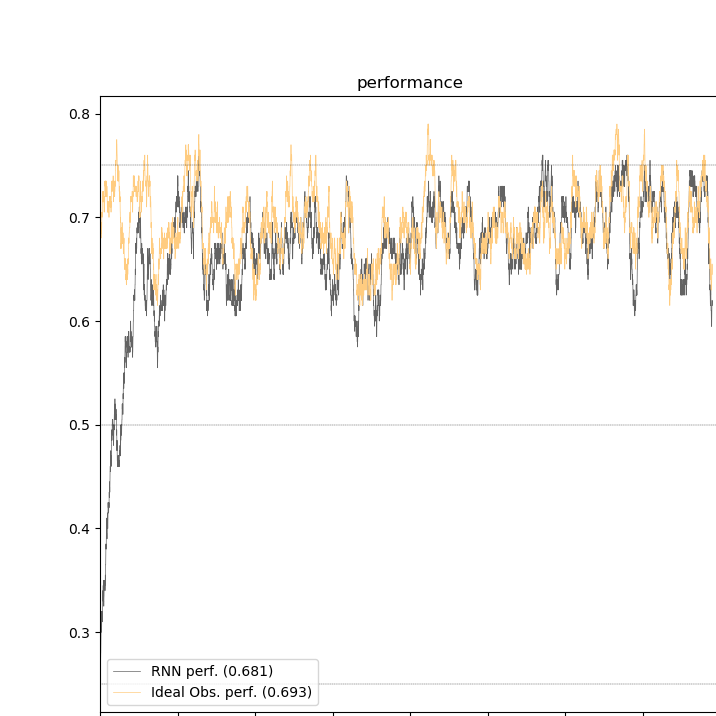

<IPython.core.display.Javascript object>


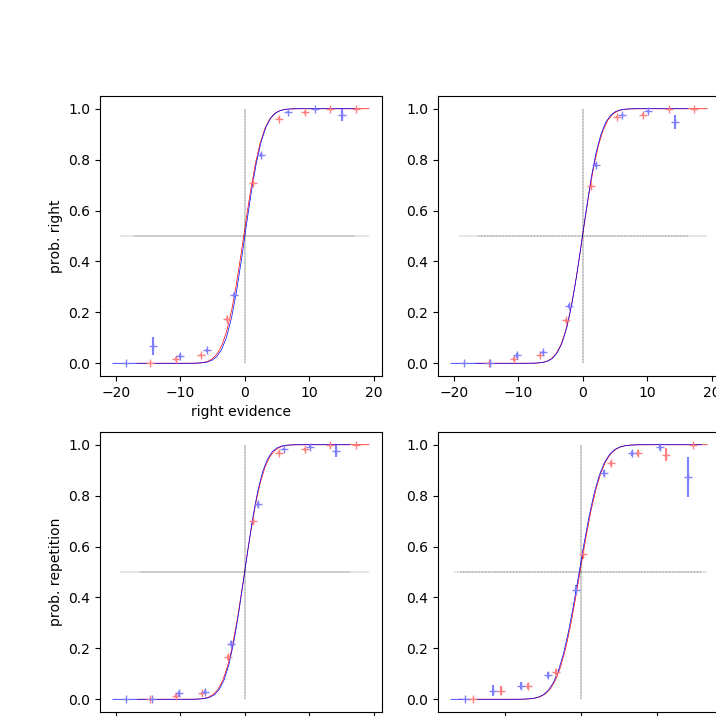

<IPython.core.display.Javascript object>


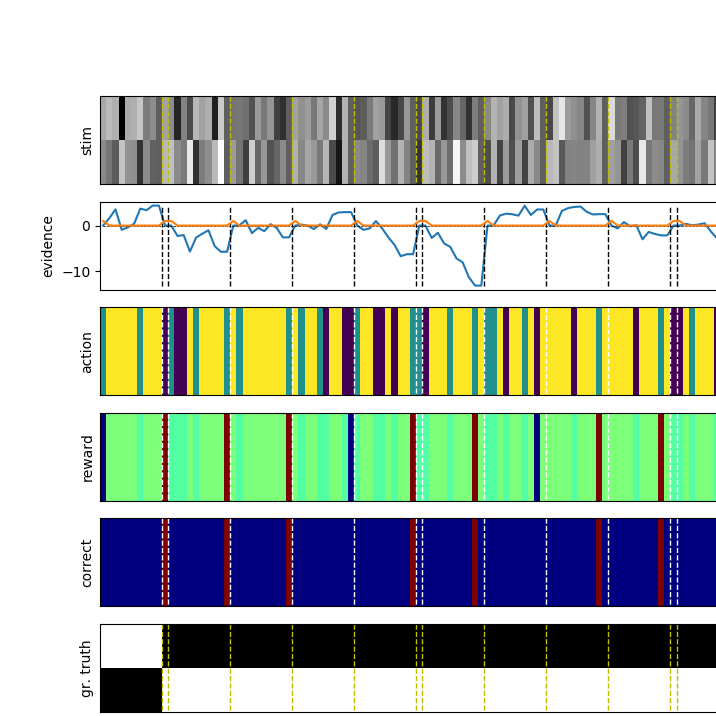

--------------- Priors experiment ---------------
Update of networks (in trials): 5
Duration of each trial (in steps): 10
Rewards: (-0.1, 0.0, 1.0, -1.0)
Duration of each block (in trials): 200
Repeating probabilities of each block: (0.2, 0.8)
Stim evidence: 0.5
Saving folder: /home/molano/priors_project/priors//trial_dur_10_rep_prob_0.2_0.8_rewards_-0.1_0.0_1.0_-1.0_block_dur_200_stimEv_0.5_gamma_0.8_num_units_32_up_net_5_net_ugru_123//trains/train_0
--------------- ----------------- ---------------
Starting worker 0
Starting worker 2
Starting worker 6Starting worker 8
Starting worker 5
Starting worker 1
Starting worker 7
Starting worker 4
Starting worker 9

Starting worker 11
Starting worker 10
Starting worker 3


/home/molano/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/molano/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
main_priors(load_model=False, train=True, gamma=.8, up_net=5,
                trial_dur=10, rep_prob=(0.2, 0.8), exp_dur=10**6,
                rewards=(-0.1, 0.0, 1.0, -1.0), block_dur=200,
                num_units=32, stim_ev=0.5, network='ugru',
                learning_rate=1e-3, instance=123, main_folder='/home/molano/priors_project/priors/')